# Recommendation Systems with TensorFlow

Outline
- Exploring the MovieLens Data 
- Preliminaries 
- Training a matrix factorization model 
- Inspecting the Embeddings 
- Regularization in matrix factorization 
- Softmax model training 

In [3]:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
from __future__ import print_function
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow as tf
import altair as alt
import datapane as dp
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
tf.compat.v1.enable_eager_execution()
tf.config.run_functions_eagerly(True)
# tf.disable_v2_behavior()
# tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format

In [6]:
input_file_path = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/raw/'
output_files = '/Users/gauridhumal/Development Projects/UOL-PROJECTs/CRS/DS/crs_ds/data/processed/outputs'

In [7]:
def read_file(file_name):
    return pd.read_csv(open(f"{input_file_path}/{file_name}", 'r'))

In [8]:
def write_file(df,file_name):
    return df.to_csv(f"{output_files}/{file_name}", index=False)

In [9]:
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

In [10]:
def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

In [11]:
pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [12]:
alt.data_transformers.enable('default', max_rows=None)
# alt.renderers.enable('jupyterlab')

DataTransformerRegistry.enable('default')

# Load each data set (users, movies, and ratings).

## Users

In [13]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']

In [14]:
file_name = 'ml-100k/u.user'

In [15]:
users = pd.read_csv(f"{input_file_path}/{file_name}"
    , sep='|', names=users_cols, encoding='latin-1')

In [16]:
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [17]:
users.describe(include='all')

,user_id,age,sex,occupation,zip_code
count,943.000,943.000,943,943,943
unique,NaN,NaN,2,21,795
top,NaN,NaN,M,student,55414
freq,NaN,NaN,670,196,9
mean,472.000,34.052,NaN,NaN,NaN
...,...,...,...,...,...
min,1.000,7.000,NaN,NaN,NaN
25%,236.500,25.000,NaN,NaN,NaN
50%,472.000,31.000,NaN,NaN,NaN
75%,707.500,43.000,NaN,NaN,NaN


In [18]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   sex         943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


In [19]:
# Unique values in each column
for column in users.columns:
    print(column, len(users[column].unique()))

user_id 943
age 61
sex 2
occupation 21
zip_code 795


In [20]:
users.isnull().any()

user_id       False
age           False
sex           False
occupation    False
zip_code      False
dtype: bool

In [21]:

profile = ProfileReport(users, title="Pandas Profiling Report for movielense_user data",
                   dataset={
        "description": "This profiling report was generated for End of Module Project for UoL",
    },)
profile.to_file("user_analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Ratings

In [22]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
file_name = 'ml-100k/u.data'
ratings = pd.read_csv(f"{input_file_path}/{file_name}", sep='\t', names=ratings_cols, encoding='latin-1')

In [23]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [24]:
profile = ProfileReport(ratings, title="Pandas Profiling Report for movielense_user_rating data",
                   dataset={
        "description": "This profiling report was generated for End of Module Project for UoL",
    },)
profile.to_file("rating_analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Genre

In [25]:
genre_cols = ['title', 'id',]
file_name = 'ml-100k/u.genre'
genre = pd.read_csv(f"{input_file_path}/{file_name}", sep='|', names=genre_cols, encoding='latin-1')

In [26]:
genre.head()

,title,id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [27]:
genre_c_name=list(genre['title'])

## Movies

In [28]:
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_c_name
file_name = 'ml-100k/u.item'
movies = pd.read_csv(f"{input_file_path}/{file_name}", sep='|', names=movies_cols, encoding='latin-1')

In [29]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [30]:
profile = ProfileReport(movies, title="Pandas Profiling Report for movielense_movie data",
                   dataset={
        "description": "This profiling report was generated for End of Module Project for UoL",
    },)
profile.to_file("movie_analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [31]:
# Since the ids start at 1, we shift them to start at 0.

In [32]:
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [33]:
users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [34]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995


In [35]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.000,881250949
1,185,301,3.000,891717742
2,21,376,1.000,878887116
3,243,50,2.000,880606923
4,165,345,1.000,886397596


In [36]:
# Compute the number of movies to which a genre is assigned.
genre_occurences = movies[genre_c_name].sum().to_dict()

In [37]:
genre_occurences

{'unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 "Children's": 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [38]:
# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

In [39]:
mark_genres(movies, genre_c_name)

In [40]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995,Children's,Animation-Children's-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Crime-Drama-Thriller


In [41]:
# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [42]:
movielens .head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.000,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.000,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,0,0,1997,Action,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.000,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,0,0,1996,Comedy,Comedy-Romance,49,M,writer,55105
3,195,24,4.000,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.000,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


In [43]:
profile = ProfileReport(movielens, title="Pandas Profiling Report for movielense data",
                   dataset={
        "description": "This profiling report was generated for End of Module Project for UoL",
    },)
profile.to_file("movielens_analysis.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
movies_ratings = movies.merge(
    ratings
    .groupby('movie_id', as_index=False)
    .agg({'rating': ['count', 'mean']})
    .flatten_cols(),
    on='movie_id')

In [45]:
movies_ratings

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres,rating count,rating mean
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,1995,Children's,Animation-Children's-Comedy,452,3.878
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,1,0,0,1995,Thriller,Action-Adventure-Thriller,131,3.206
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,1,0,0,1995,Thriller,Thriller,90,3.033
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,1995,Comedy,Action-Comedy-Drama,209,3.550
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,1,0,0,1995,Thriller,Crime-Drama-Thriller,86,3.302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1677,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,1998,Drama,Drama,1,1.000
1678,1678,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,1,0,1,0,0,1998,Romance,Romance-Thriller,1,3.000
1679,1679,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,1,0,0,0,0,1998,Drama,Drama-Romance,1,2.000
1680,1680,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,1994,Comedy,Comedy,1,3.000


## Utility functions 

In [46]:
# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

In [164]:
def build_rating_sparse_tensor(ratings_df):
    """
    Args:
    ratings_df: a pd.DataFrame with `user_id`, `movie_id` and `rating` columns.
    Returns:
    A tf.SparseTensor representing the ratings matrix.
    """
    indices = ratings_df[['user_id','movie_id']].values

    values = ratings_df['rating'].values
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[users.shape[0], movies.shape[0]])

## Collaborative Filtering Recommendations
Our goal is to factorize the ratings matrix $A$ into the product of a user embedding matrix $U$ and movie embedding matrix $V$, such that $A \approx UV^\top$ with
$U = \begin{bmatrix} u_{1} \\ \hline \vdots \\ \hline u_{N} \end{bmatrix}$ and
$V = \begin{bmatrix} v_{1} \\ \hline \vdots \\ \hline v_{M} \end{bmatrix}$.

Here
- $N$ is the number of users,
- $M$ is the number of movies,
- $A_{ij}$ is the rating of the $j$th movies by the $i$th user,
- each row $U_i$ is a $d$-dimensional vector (embedding) representing user $i$,
- each row $V_j$ is a $d$-dimensional vector (embedding) representing movie $j$,
- the prediction of the model for the $(i, j)$ pair is the dot product $\langle U_i, V_j \rangle$.

### Matrix factorisation using small example.

In [48]:
d = {'user_id': [0,0,1,2,2], 'movie_id': [0,1,1,2,3],'ratings': [3,1,5,2,5]}

In [49]:
df = pd.DataFrame(data=d)
df

,user_id,movie_id,ratings
0,0,0,3
1,0,1,1
2,1,1,5
3,2,2,2
4,2,3,5


In [50]:
indices = df[['user_id','movie_id']].values
indices

array([[0, 0],
       [0, 1],
       [1, 1],
       [2, 2],
       [2, 3]])

In [51]:
values = df['ratings'].values

In [52]:
values

array([3, 1, 5, 2, 5])

In [53]:
users.shape[0]
movies.shape[0]

943

1682

In [54]:
sparse_rating_t = tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[4, 4])

In [55]:
sparse_rating_t

SparseTensor(indices=tf.Tensor(
[[0 0]
 [0 1]
 [1 1]
 [2 2]
 [2 3]], shape=(5, 2), dtype=int64), values=tf.Tensor([3 1 5 2 5], shape=(5,), dtype=int64), dense_shape=tf.Tensor([4 4], shape=(2,), dtype=int64))

In [56]:
sparse_rating_t.indices

<tf.Tensor: shape=(5, 2), dtype=int64, numpy=
array([[0, 0],
       [0, 1],
       [1, 1],
       [2, 2],
       [2, 3]])>

In [57]:
# value at position index 2 -[1,5] and a specific column
sparse_rating_t.indices[2,1]

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [58]:
# value at position index 2 -[1,5] and all columns
sparse_rating_t.indices[2,:]

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 1])>

In [59]:
# value at all indices and all columns
sparse_rating_t.indices[:,:]

<tf.Tensor: shape=(5, 2), dtype=int64, numpy=
array([[0, 0],
       [0, 1],
       [1, 1],
       [2, 2],
       [2, 3]])>

In [60]:
# value at all indices and a specific column
sparse_rating_t.indices[:,1]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 1, 2, 3])>

In [61]:
sparse_rating_t.indices[:, 0]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 1, 2, 2])>

In [62]:
params = tf.constant([[0, 1.0, 2.0],
                      [10.0, 11.0, 12.0],
                      [20.0, 21.0, 22.0],
                      [30.0, 31.0, 32.0]])

In [63]:
tf.gather(params, indices=[3,2]).numpy()

array([[30., 31., 32.],
       [20., 21., 22.]], dtype=float32)

In [64]:
u_emb_raw = {'user_id': [0,1,2,3], 'dim1': [0,1,0,1],'dim2': [1,1,0,1],'dim3': [1,1,1,1],'dim4': [0,1,0,1],'dim5': [0,1,0,1],}

In [65]:
df_u = pd.DataFrame(data=u_emb_raw)

In [66]:
df_u

,user_id,dim1,dim2,dim3,dim4,dim5
0,0,0,1,1,0,0
1,1,1,1,1,1,1
2,2,0,0,1,0,0
3,3,1,1,1,1,1


In [67]:
df_u.shape

(4, 6)

In [68]:
u_emb = tf.convert_to_tensor(df_u)

In [69]:
u_emb

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 1, 0, 0],
       [3, 1, 1, 1, 1, 1]])>

In [70]:
m_emb_raw = {'movie_id': [0,1,2,3], 'dim1': [0,1,0,1],'dim2': [1,1,0,1],'dim3': [0,1,0,1],'dim4': [1,1,1,1],'dim5': [0,1,1,1],}

In [71]:
df_m = pd.DataFrame(data=m_emb_raw)

In [72]:
m_emb = tf.convert_to_tensor(df_m)

In [73]:
m_emb

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 0, 1, 1],
       [3, 1, 1, 1, 1, 1]])>

In [74]:
u_emb

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 1, 0, 0],
       [3, 1, 1, 1, 1, 1]])>

In [75]:
sparse_rating_t.indices[:, 0]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 1, 2, 2])>

In [76]:
tf.gather(u_emb, sparse_rating_t.indices[:, 0])
# repeats the number of u_emb rows depending on the sparse_rating_t i- user id

<tf.Tensor: shape=(5, 6), dtype=int64, numpy=
array([[0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 1, 0, 0],
       [2, 0, 0, 1, 0, 0]])>

In [77]:
m_emb

<tf.Tensor: shape=(4, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 0, 1, 1],
       [3, 1, 1, 1, 1, 1]])>

In [78]:
sparse_rating_t.indices[:, 1]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 1, 2, 3])>

In [79]:
tf.gather(m_emb, sparse_rating_t.indices[:, 1])

<tf.Tensor: shape=(5, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [2, 0, 0, 0, 1, 1],
       [3, 1, 1, 1, 1, 1]])>

In [80]:

tf.gather(u_emb, sparse_rating_t.indices[:, 0]) * tf.gather(m_emb, sparse_rating_t.indices[:, 1])

<tf.Tensor: shape=(5, 6), dtype=int64, numpy=
array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 1],
       [4, 0, 0, 0, 0, 0],
       [6, 0, 0, 1, 0, 0]])>

In [81]:
# sum all the elements
predictions = tf.reduce_sum(tf.gather(u_emb, sparse_rating_t.indices[:, 0]) * tf.gather(m_emb, sparse_rating_t.indices[:, 1]),axis=1)

In [82]:
predictions

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 6, 4, 7])>

In [83]:
sparse_rating_t.values

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([3, 1, 5, 2, 5])>

In [84]:
loss = tf.losses.mean_squared_error(sparse_rating_t.values, predictions)

In [85]:
loss

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [86]:
loss.numpy()

2

### Calculating the error

The model approximates the ratings matrix $A$ by a low-rank product $UV^\top$. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only (we will revisit this later). It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$
where $\Omega$ is the set of observed ratings, and $|\Omega|$ is the cardinality of $\Omega$.


### Recommendation using added values (optional)

In [ ]:
# Add a record for the user
users.head()
last_id = users.index.values.max()
users.loc[last_id+1] = [last_id+1,42,"F","technician","34556"]

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [ ]:
users.tail()

,user_id,age,sex,occupation,zip_code
939,939,32,M,administrator,02215
940,940,20,M,student,97229
941,941,48,F,librarian,78209
942,942,22,M,student,77841
943,943,42,F,technician,34556


In [ ]:
# Add the ratings by this user
ratings.tail()
last_id = ratings.index.values.max()
ratings.loc[last_id+1] = ['943','275',2.000,880606923]
ratings.loc[last_id+2] = ['943','225',2.000,880606923]
ratings.loc[last_id+3] = ['943','241',5.000,880606923]

,user_id,movie_id,rating,unix_timestamp
99995,879,475,3.000,880175444
99996,715,203,5.000,879795543
99997,275,1089,1.000,874795795
99998,12,224,2.000,882399156
99999,11,202,3.000,879959583


In [ ]:
#ratings= ratings.drop([ratings.index[100000],ratings.index[100001],ratings.index[100002]])

In [ ]:
ratings.tail()

,user_id,movie_id,rating,unix_timestamp
99998,12,224,2.000,882399156
99999,11,202,3.000,879959583
100000,943,275,2.000,880606923
100001,943,225,2.000,880606923
100002,943,241,5.000,880606923


In [88]:
def sparse_mean_square_error_obs_and_unobserved(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  # ========================= Complete this section ============================
    #  Matrix multiplication
  predictions = tf.gather_nd(
  tf.math.multiply(user_embeddings, movie_embeddings, transpose_b=True),
  sparse_ratings.indices)
  loss = tf.keras.losses.MeanSquaredError(sparse_ratings.values, predictions)
  return loss

  # ============================================================================

Note: One approach is to compute the full prediction matrix  𝑈𝑉⊤ , then gather the entries corresponding to the observed pairs. The memory cost of this approach is  𝑂(𝑁𝑀) . For the MovieLens dataset, this is fine, as the dense  𝑁×𝑀  matrix is small enough to fit in memory ( 𝑁=943 ,  𝑀=1682 ).

Another approach (given in the alternate solution below) is to only gather the embeddings of the observed pairs, then compute their dot products. The memory cost is  𝑂(|Ω|𝑑)  where  𝑑  is the embedding dimension. In our case,  |Ω|=105 , and the embedding dimension is on the order of  10 , so the memory cost of both methods is comparable. But when the number of users or movies is much larger, the first approach becomes infeasible.

In [89]:
def sparse_mean_square_error_observed_pairs_only(sparse_ratings, user_embeddings, movie_embeddings):
  """
  Args:
    sparse_ratings: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    movie_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
      tf.gather(movie_embeddings, sparse_ratings.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
  return loss

# III. Training a Matrix Factorization model
This is a simple class to train a matrix factorization model using stochastic gradient descent.
The class constructor takes
- the user embeddings U (a `tf.Variable`).
- the movie embeddings V, (a `tf.Variable`).
- a loss to optimize (a `tf.Tensor`).
- an optional list of metrics dictionaries, each mapping a string (the name of the metric) to a tensor. These are evaluated and plotted during training (e.g. training error and test error).

After training, one can access the trained embeddings using the `model.embeddings` dictionary.

Example usage:
```
U_var = ...
V_var = ...
loss = ...
model = CFModel(U_var, V_var, loss)
model.train(iterations=100, learning_rate=1.0)
user_embeddings = model.embeddings['user_id']
movie_embeddings = model.embeddings['movie_id']
```

### Build a Matrix Factorization model and train it

In [90]:
def train(num_iterations=1, learning_rate=1.0, plot_results=True,optimizer=tf.keras.optimizers.legacy.SGD,ratings=ratings,embedding_dim=3, init_stddev=1.):
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
  # ========================= Complete this section ============================
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
  # ============================================================================
  # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[0], embedding_dim]))
    V = tf.Variable(tf.random_normal_initializer(stddev=init_stddev)(shape=[A_train.dense_shape[1], embedding_dim]))
    loss_result = pd.DataFrame(columns =['train_loss', 'test_loss','learning_rate',])
    print("num_iterations: " + str(num_iterations))
    for i in range(num_iterations + 1):
        # print("\r iteration %d: " % i )
        # print("learning_rate: " + str(learning_rate))
        opt = optimizer(learning_rate)
        with tf.GradientTape() as tape:
          train_loss = sparse_mean_square_error_observed_pairs_only(A_train,U,V)
          test_loss = sparse_mean_square_error_observed_pairs_only(A_test,U,V)
          loss_result.loc[i] = [train_loss.numpy(), test_loss.numpy(),learning_rate,]
          # print(train_loss.numpy())
          # print(test_loss.numpy())
        # Compute the gradients for a list of variables.
        grads = tape.gradient(train_loss, [U,V])
        # Ask the optimizer to apply the gradients on variables.
        opt_emb = opt.apply_gradients(zip(grads,[U, V]))
        # learning_rate = learning_rate/10
    return loss_result,opt_emb,U,V


In [91]:
loss_result,opt_emb,U,V = train(num_iterations=1000,learning_rate=10,init_stddev=0.5,embedding_dim=30)

num_iterations: 1000


In [102]:
opt_emb

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

In [92]:
loss_result.shape

(1001, 3)

In [93]:
loss_result

,train_loss,test_loss,learning_rate
0,15.577,15.646,10.000
1,15.407,15.577,10.000
2,15.249,15.513,10.000
3,15.098,15.454,10.000
4,14.954,15.397,10.000
...,...,...,...
996,0.377,1.392,10.000
997,0.376,1.392,10.000
998,0.376,1.392,10.000
999,0.376,1.392,10.000


Text(0.5, 0, 'Iterations')

Text(0, 0.5, 'Loss')

Text(0.5, 1.0, 'SGD Optimiser for Loss function')

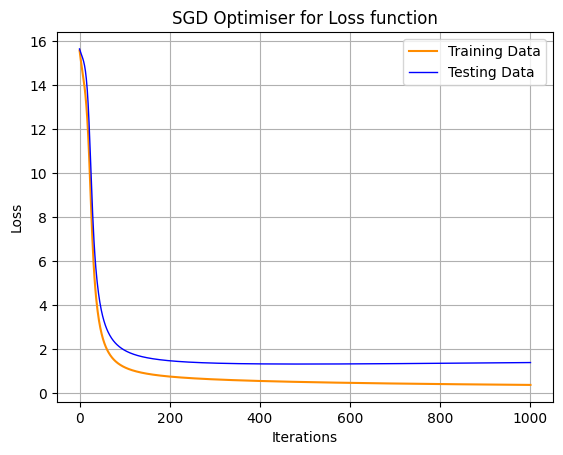

In [94]:
lw = 1
%matplotlib inline
plt.plot(loss_result.index, loss_result['train_loss'], color='darkorange', label='Training Data')
plt.plot(loss_result.index,loss_result['test_loss'], color='blue', linewidth=lw, label='Testing Data')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('SGD Optimiser for Loss function')
plt.legend()
plt.grid(True)
plt.show()

### Inspecting the Embeddings
In this section, we take a closer look at the learned embeddings, by

- computing your recommendations
- looking at the nearest neighbors of some movies,
- looking at the norms of the movie embeddings,
- isualizing the embedding in a projected embedding space.

We will compare the following:

- dot product: the score of item j is $\langle u, V_j \rangle$.
- cosine: the score of item j is $\frac{\langle u, V_j \rangle}{\|u\|\|V_j\|}$.

you can use np.dot to compute the product of two np.Arrays.
you can use np.linalg.norm to compute the norm of a np.Array.

In [98]:
# Optimised movie embeddings
V.numpy()

array([[ 0.4648256 ,  0.3148938 ,  0.11922972, ...,  0.04556944,
         0.19414662,  0.37603816],
       [ 0.3761877 , -0.5462725 ,  0.833188  , ...,  0.4039664 ,
        -0.33280924,  0.6171561 ],
       [ 1.1400373 ,  0.4413067 , -0.96235716, ...,  0.28519687,
        -0.19020543,  0.2430432 ],
       ...,
       [ 0.68923557, -0.45789   ,  0.39066908, ..., -0.46539494,
        -0.6030682 ,  0.415531  ],
       [ 0.46427473,  0.31411093, -0.12962328, ..., -0.19515826,
         0.303185  ,  1.0140117 ],
       [ 0.7005912 ,  0.52951664,  0.03610032, ...,  0.6613713 ,
         1.1422231 ,  0.40841615]], dtype=float32)

In [97]:
# Optimised user embeddings
U.numpy()

array([[ 1.3542126 , -0.2822563 ,  0.556057  , ...,  0.49455115,
         1.0371846 ,  0.21379133],
       [ 0.3980319 , -0.3001165 , -0.526026  , ...,  0.20915602,
         0.29483482,  0.52366716],
       [ 0.52391493, -0.46017507, -0.81470305, ..., -0.25079134,
         0.26542988, -0.61493385],
       ...,
       [ 0.6713481 , -0.1754282 ,  0.74735993, ...,  0.4446521 ,
        -0.7115247 ,  0.28594708],
       [ 0.57115763, -0.2851273 , -0.00310127, ...,  0.19567205,
         0.39744183, -0.5327469 ],
       [ 0.6158463 , -0.94735634, -0.3608884 , ..., -0.15908322,
        -0.11624185,  0.72398335]], dtype=float32)

In [117]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

### Recommendations using DOT product

In [133]:
def user_recommendations(user_id,measure=DOT):
    query_embedding = U.numpy()[user_id]
    item_embeddings = V.numpy()
    scores = compute_scores(query_embedding, item_embeddings, measure=DOT)
    score_key = measure+"_"+ 'score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    return df

In [162]:
# Testing of the recommendations
user_id = 1 # Recommendation for this user
measure = "DOT" # Use of DOT product or Cosine simialrity
exclude_rated = True # Flag to indicate if already rated movies by this user can be excluded from the final recommendation
k=6 # Number of movies to be recommended
df = user_recommendations(user_id,measure)
score_key = measure+"_"+ 'score'
if exclude_rated:
    # remove movies that are already rated
    rated_movies = ratings[ratings.user_id == user_id]["movie_id"].values
    df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]

df.sort_values([score_key],ascending=False).head(k)

,DOT_score,movie_id,titles,genres
958,6.467,958,Dazed and Confused (1993),Comedy
1203,6.123,1203,To Be or Not to Be (1942),Comedy-Drama-War
343,5.767,343,"Apostle, The (1997)",Drama
514,5.670,514,"Boot, Das (1981)",Action-Drama-War
345,5.502,345,Jackie Brown (1997),Crime-Drama
600,5.447,600,For Whom the Bell Tolls (1943),Adventure-War


In [163]:
# Verify if the recommendations are accurate to users historic liking.
movielens[movielens["user_id"] == '1'].sort_values(["rating"],ascending=False).head(20)

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
3928,1,241,5.000,888552084,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,53,F,other,94043
3985,1,310,5.000,888552084,"Wings of the Dove, The (1997)",01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Wings+of+the+...,0,0,...,1,0,0,1997,Thriller,Drama-Romance-Thriller,53,F,other,94043
3972,1,284,5.000,888552084,Secrets & Lies (1996),04-Oct-1996,NaN,http://us.imdb.com/M/title-exact?Secrets%20&%2...,0,0,...,0,0,0,1996,Drama,Drama,53,F,other,94043
3976,1,315,5.000,888979693,As Good As It Gets (1997),23-Dec-1997,NaN,http://us.imdb.com/Title?As+Good+As+It+Gets+(1...,0,0,...,0,0,0,1997,Drama,Comedy-Drama,53,F,other,94043
3975,1,282,5.000,888552084,Emma (1996),02-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Emma%20(1996),0,0,...,0,0,0,1996,Drama,Drama-Romance,53,F,other,94043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,1,285,4.000,888549960,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,...,0,1,0,1996,Drama,Drama-Romance-War,53,F,other,94043
3964,1,283,4.000,888552017,Tin Cup (1996),16-Aug-1996,NaN,http://us.imdb.com/M/title-exact?Tin%20Cup%20(...,0,0,...,0,0,0,1996,Comedy,Comedy-Romance,53,F,other,94043
3965,1,291,4.000,888550774,Rosewood (1997),21-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Rosewood%20(1...,0,0,...,0,0,0,1997,Drama,Drama,53,F,other,94043
3974,1,298,4.000,888550774,Hoodlum (1997),22-Aug-1997,NaN,http://us.imdb.com/M/title-exact?Hoodlum+(1997),0,0,...,0,0,0,1997,Film-Noir,Crime-Drama-Film-Noir,53,F,other,94043


In [126]:
# against each movie rating the score of this user is compared.
df

,DOT score,movie_id,titles,genres
0,3.908,0,Toy Story (1995),Animation-Children's-Comedy
1,2.163,1,GoldenEye (1995),Action-Adventure-Thriller
2,3.115,2,Four Rooms (1995),Thriller
3,3.179,3,Get Shorty (1995),Action-Comedy-Drama
4,3.278,4,Copycat (1995),Crime-Drama-Thriller
...,...,...,...,...
1677,-0.318,1677,Mat' i syn (1997),Drama
1678,0.076,1678,B. Monkey (1998),Romance-Thriller
1679,0.865,1679,Sliding Doors (1998),Drama-Romance
1680,1.262,1680,You So Crazy (1994),Comedy


In [ ]:
def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["movie_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'movie_id': movies['movie_id'],
        'titles': movies['title'],
        'genres': movies['all_genres'],
    })
    if exclude_rated:
      # remove movies that are already rated
      rated_movies = ratings[ratings.user_id == "943"]["movie_id"].values
      df = df[df.movie_id.apply(lambda movie_id: movie_id not in rated_movies)]
    display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
def movie_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for movie ids that match the given substring.
  ids =  movies[movies['title'].str.contains(title_substring)].index.values
  titles = movies.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no movies with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching movie. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  movie_id = ids[0]
  scores = compute_scores(
      model.embeddings["movie_id"][movie_id], model.embeddings["movie_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': movies['title'],
      'genres': movies['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

In [ ]:
user_recommendations(model, measure=COSINE, k=5)